# Spin Qubits

These examples all cover dynamical simulation of spin qubits. These examples use small systems, but note that the GPU will only provide an advantage for systems with total dimension of O(1000).

## Silicon Spin Qubit

This example demonstrates simulation of an electrically-driven silicon spin qubit taken from ["Nonlinear Response and Crosstalk of Electrically Driven Silicon Spin Qubits"](https://journals.aps.org/prapplied/pdf/10.1103/PhysRevApplied.19.044078)

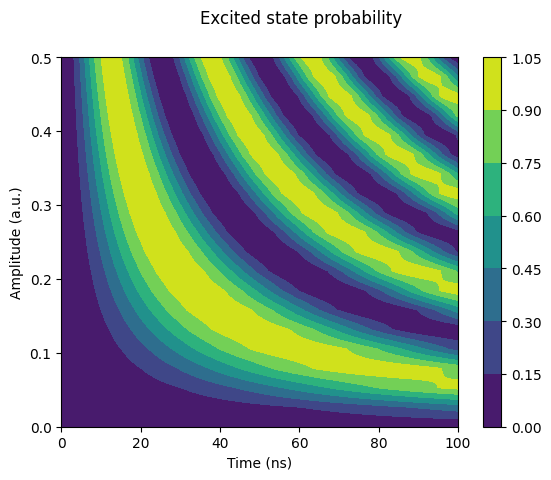

In [1]:
import cudaq
from cudaq import spin, boson, Schedule, ScalarOperator, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

dimensions = {0: 2}
resonance_frequency = 2 * np.pi * 10  # 10 Ghz

# Run the simulation:
evolution_results = []
get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]
# Sweep the amplitude
amplitudes = np.linspace(0.0, 0.5, 20)
# Construct a list of Hamiltonian operator for each amplitude so that we can batch them all together
batched_hamiltonian = []
for amplitude in amplitudes:
    # Electric dipole spin resonance (`EDSR`) Hamiltonian
    H = 0.5 * resonance_frequency * spin.z(0) + amplitude * ScalarOperator(
        lambda t: 0.5 * np.sin(resonance_frequency * t)) * spin.x(0)
    # Append the Hamiltonian to the batched list
    # This allows us to compute the dynamics for all amplitudes in a single simulation run
    batched_hamiltonian.append(H)

# Initial state is the ground state of the spin qubit
# We run all simulations for the same initial state, but with different Hamiltonian operators.
psi0 = cudaq.State.from_data(cp.array([1.0, 0.0], dtype=cp.complex128))

# Simulation schedule
t_final = 100
dt = 0.005
n_steps = int(np.ceil(t_final / dt)) + 1
steps = np.linspace(0, t_final, n_steps)
schedule = Schedule(steps, ["t"])

results = cudaq.evolve(
    batched_hamiltonian,
    dimensions,
    schedule,
    psi0,
    observables=[boson.number(0)],
    collapse_operators=[],
    store_intermediate_results=cudaq.IntermediateResultSave.EXPECTATION_VALUE,
    integrator=ScipyZvodeIntegrator())

get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]

evolution_results = []
for result in results:
    evolution_results.append(get_result(0, result))

fig, ax = plt.subplots()
im = ax.contourf(steps, amplitudes, evolution_results)
ax.set_xlabel("Time (ns)")
ax.set_ylabel(f"Amplitude (a.u.)")
fig.suptitle(f"Excited state probability")
fig.colorbar(im)

## Heisenberg Model

This example solves the [Quantum Heisenberg model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model),which exhibits the so-called quantum quench effect. See ["Quantum quenches in the anisotropic spin-1/2 Heisenberg chain: different approaches to many-body dynamics far from equilibrium"](https://iopscience.iop.org/article/10.1088/1367-2630/12/5/055017) for more details.

Text(0.5, 0, 'Time')

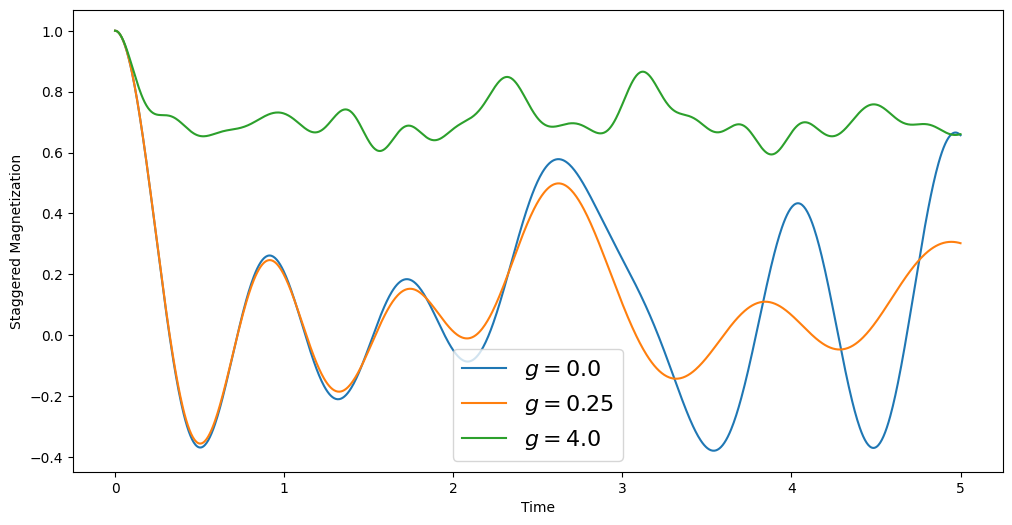

In [2]:
import cudaq
from cudaq import spin, Schedule, ScipyZvodeIntegrator

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import os

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Number of spins
N = 9
dimensions = {}
for i in range(N):
    dimensions[i] = 2

# Initial state: alternating spin up and down
spin_state = ''
for i in range(N):
    spin_state += str(int(i % 2))

# Observable is the staggered magnetization operator
staggered_magnetization_op = spin.empty()
for i in range(N):
    if i % 2 == 0:
        staggered_magnetization_op += spin.z(i)
    else:
        staggered_magnetization_op -= spin.z(i)

staggered_magnetization_op /= N

observe_results = []
batched_hamiltonian = []
anisotropy_parameters = [0.0, 0.25, 4.0]
for g in anisotropy_parameters:
    # Heisenberg model spin coupling strength
    Jx = 1.0
    Jy = 1.0
    Jz = g

    # Construct the Hamiltonian
    H = spin.empty()

    for i in range(N - 1):
        H += Jx * spin.x(i) * spin.x(i + 1)
        H += Jy * spin.y(i) * spin.y(i + 1)
        H += Jz * spin.z(i) * spin.z(i + 1)
    # Append the Hamiltonian to the batched list
    batched_hamiltonian.append(H)

steps = np.linspace(0.0, 5, 1000)
schedule = Schedule(steps, ["time"])

# Prepare the initial state vector
psi0_ = cp.zeros(2**N, dtype=cp.complex128)
psi0_[int(spin_state, 2)] = 1.0
psi0 = cudaq.State.from_data(psi0_)

# Run the simulation in batched mode
evolution_results = cudaq.evolve(
    batched_hamiltonian,
    dimensions,
    schedule,
    psi0,  # Same initial state for all Hamiltonian operators
    observables=[staggered_magnetization_op],
    collapse_operators=[],
    store_intermediate_results=cudaq.IntermediateResultSave.EXPECTATION_VALUE,
    integrator=ScipyZvodeIntegrator())

for g, evolution_result in zip(anisotropy_parameters, evolution_results):
    exp_val = [
        exp_vals[0].expectation()
        for exp_vals in evolution_result.expectation_values()
    ]

    observe_results.append((g, exp_val))

# Plot the results
fig = plt.figure(figsize=(12, 6))
for g, exp_val in observe_results:
    plt.plot(steps, exp_val, label=f'$ g = {g}$')
plt.legend(fontsize=16)
plt.ylabel("Staggered Magnetization")
plt.xlabel("Time")